In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!echo $CUDA_VISIBLE_DEVICES

1


In [ ]:
import chex
chex.__version__

In [2]:
import sys
sys.path.insert(0, "../")

import os
os.chdir("../")

In [18]:
from examples.qm9 import *
from examples.train import plot_sample_hist, eval_fn, original_dataset_to_joint_dataset, default_plotter
import yaml
import matplotlib.pyplot as plt

In [4]:
USE_64_BIT = False
if USE_64_BIT:
    from jax.config import config
    config.update("jax_enable_x64", True)

In [5]:
cfg = DictConfig(yaml.safe_load(open("examples/config/qm9.yaml")))
cfg

{'hydra': {'job': {'chdir': False}}, 'target': {'aug_global_centering': False, 'aug_scale': 0.1}, 'flow': {'base': {'aug_scale_init': '${target.aug_scale}', 'double_centrered_gaussian': False}, 'dim': 3, 'nodes': 19, 'n_layers': 8, 'identity_init': True, 'type': ['proj'], 'act_norm': False, 'kwargs': {'proj_v2': {'global_frame': False, 'process_flow_params_jointly': False, 'condition_on_x_proj': True, 'gram_schmidt': False, 'mlp_function_units': [64, 64]}}, 'fast_compile': True, 'compile_n_unroll': 1, 'egnn': {'emile_net': False, 'mlp_units': [128, 128], 'n_layers': 3, 'normalize_by_norms': True, 'variance_scaling_init': 0.001, 'tanh': False, 'agg': 'mean', 'phi_x_max': 1.0, 'normalization_constant': 1.0, 'h': {'linear_softmax': True, 'share_h': True, 'h_embedding_dim': 16}}, 'transformer': {'mlp_units': [64, 64], 'num_heads': 6, 'key_size': 16, 'w_init_scale': 0.1, 'n_layers': 3}}, 'training': {'lr': '1e-4', 'use_64_bit': False, 'optimizer_name': 'adam', 'n_epoch': 60, 'batch_size': 3

In [6]:
cfg.training.lr = 4e-4
cfg.flow.type = "vector_scale_shift"
cfg.flow.n_layers=4
cfg.flow.egnn.mlp_units = (16,)
cfg.flow.transformer.mlp_units = (16,)
cfg.flow.egnn.n_layers = 3
cfg.training.batch_size = 100
cfg.training.n_epoch = 80
cfg.training.save = False
cfg.training.plot_batch_size = 128
cfg.logger = DictConfig({"list_logger": None})
cfg.training.n_plots = 4
cfg.training.n_eval = 4
cfg.training.K_marginal_log_lik = 5

creating flow of type vector_scale_shift
training data shape of (13800, 19, 3)


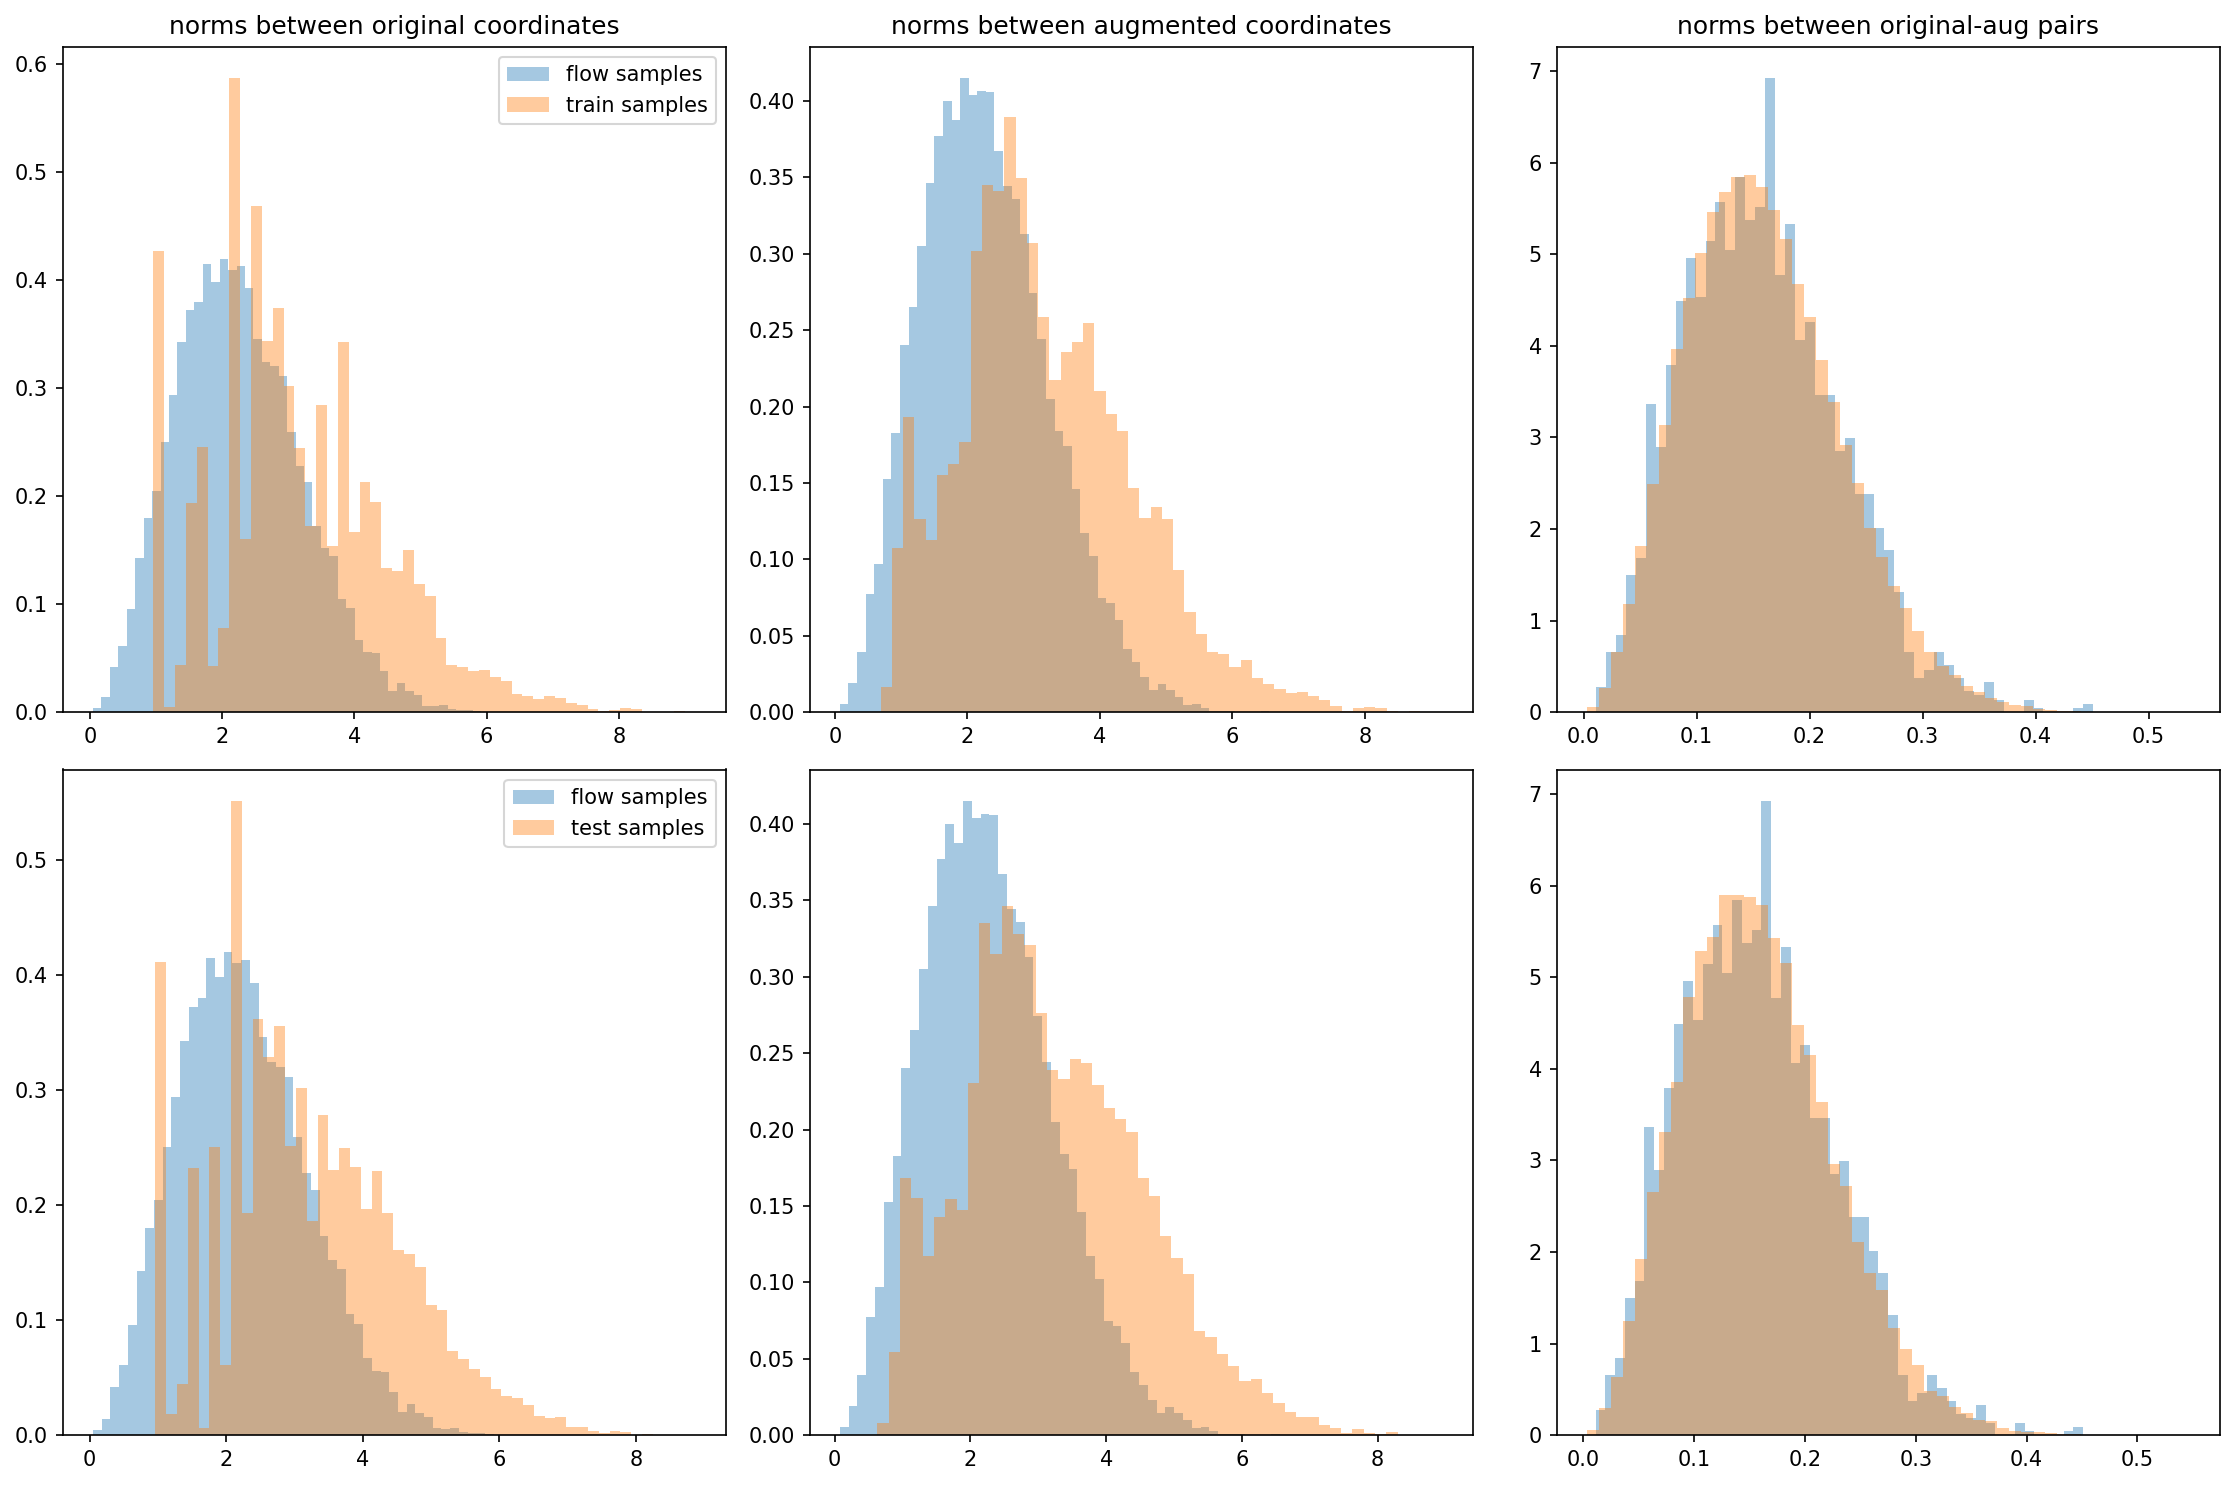

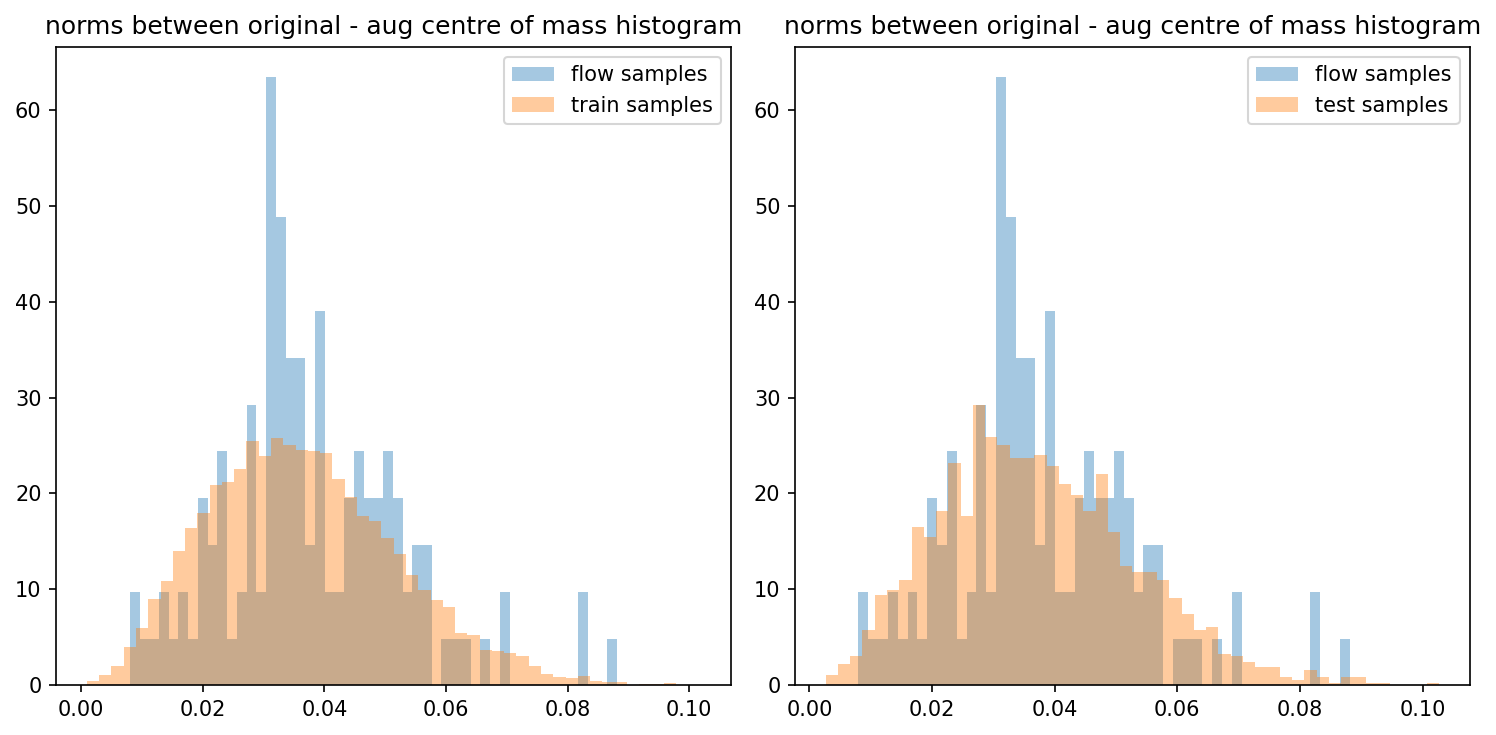

  0%|                                                    | 0/80 [00:00<?, ?it/s]

non numeric history values being saved


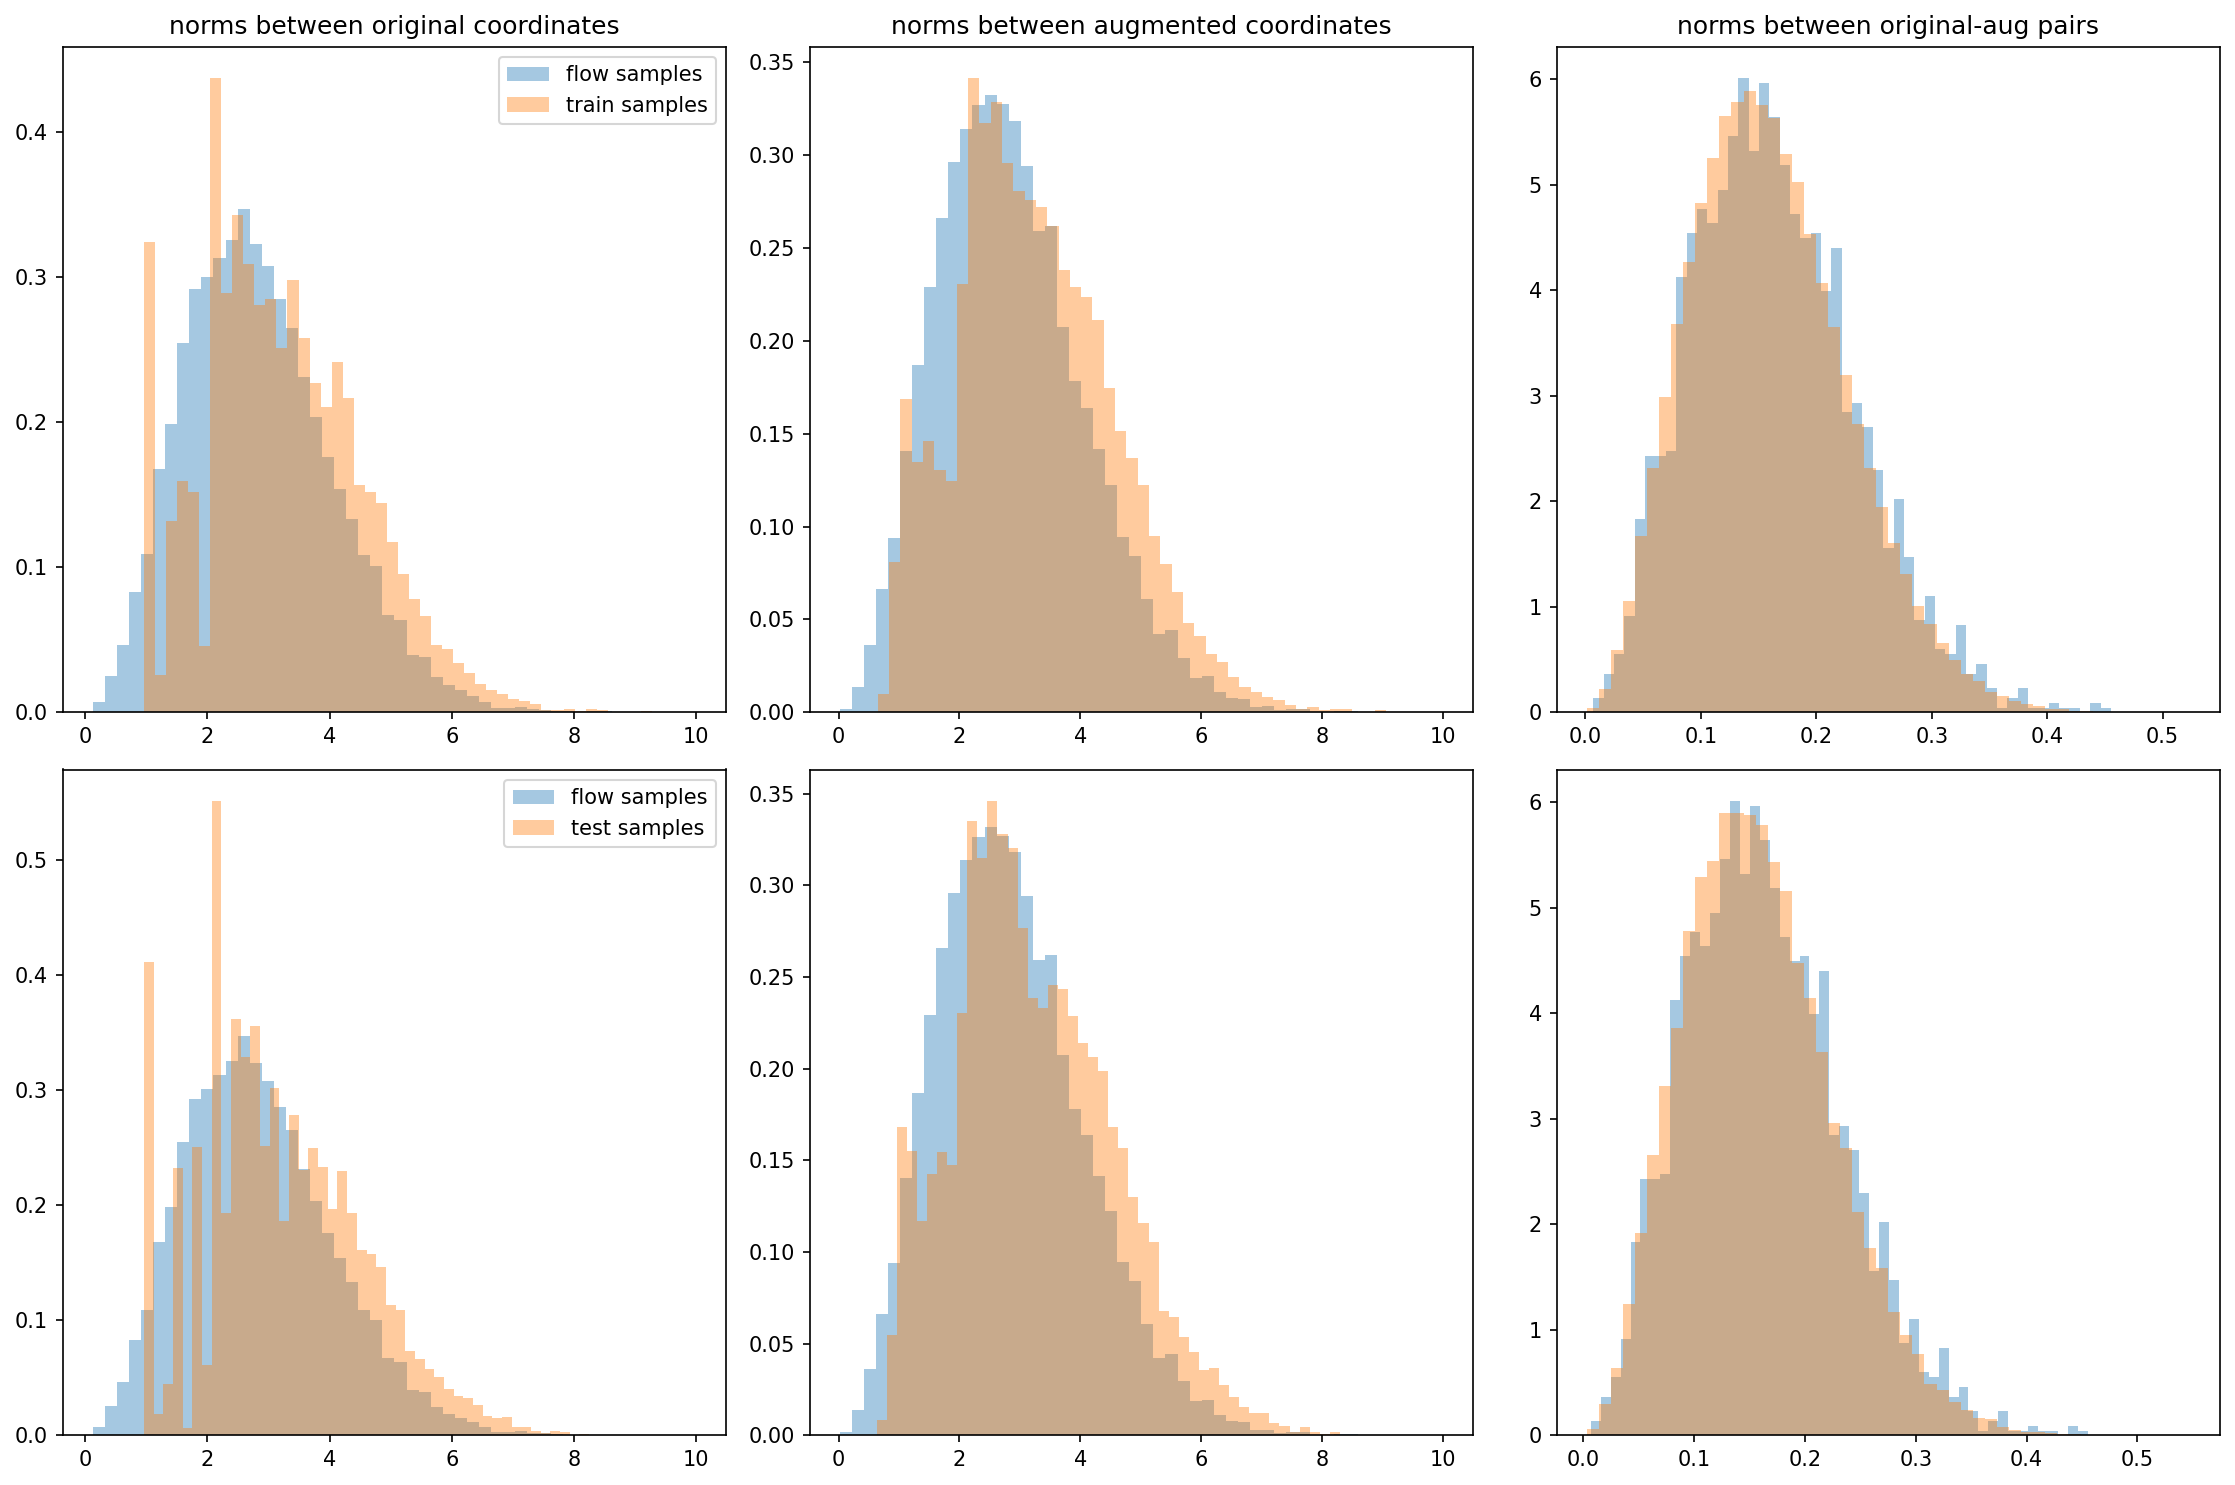

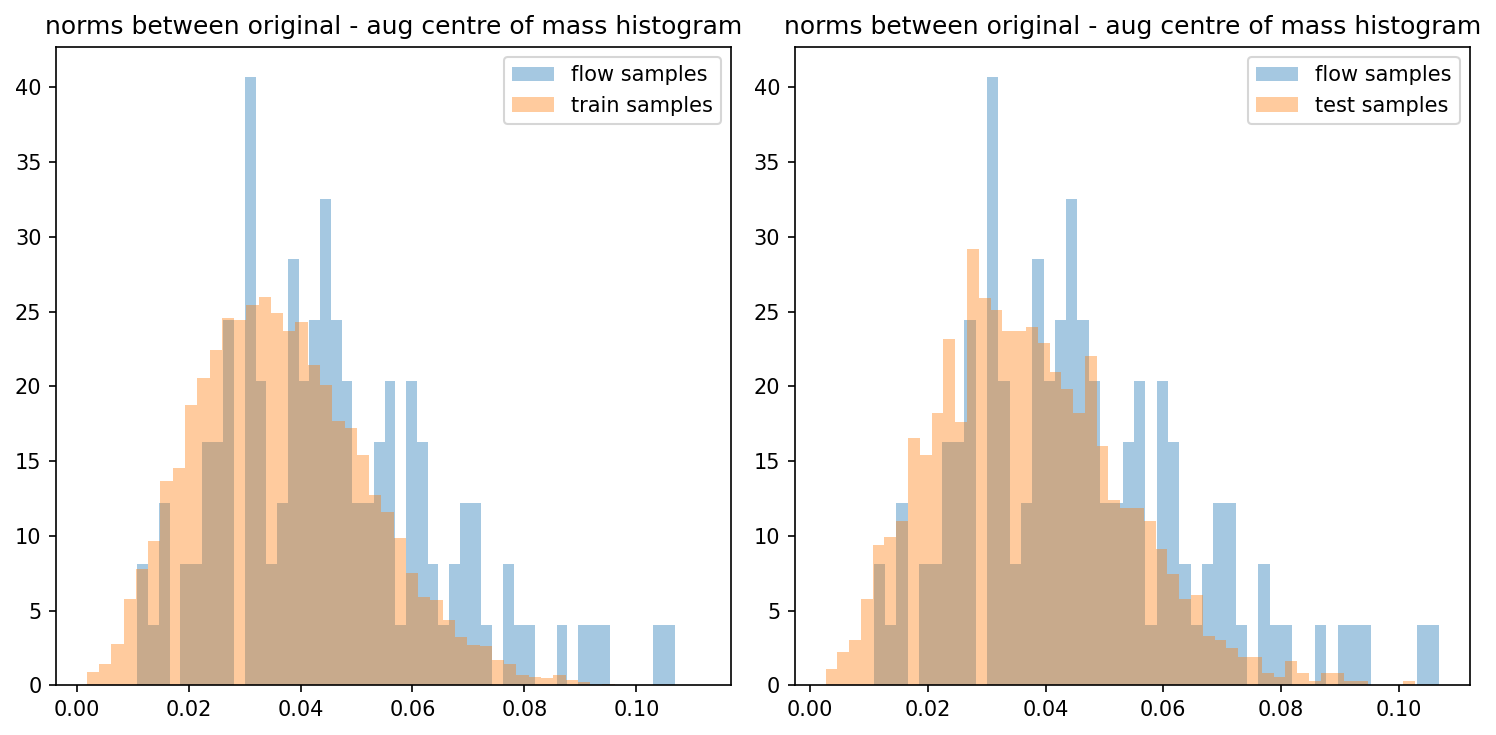

  1%|▌                                         | 1/80 [00:47<1:02:25, 47.41s/it]

{'eval_log_lik': Array(-46.771004, dtype=float32), 'eval_marginal_log_lik': Array(-92.13356, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(7.67178e-05, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(1.7636616e-05, dtype=float32), 'mean_aug_orig_norm': Array(0.04554031, dtype=float32), 'mean_diff_x_space_after_group_action': Array(1.9369981, dtype=float32)}


 32%|█████████████▉                             | 26/80 [03:33<06:00,  6.67s/it]

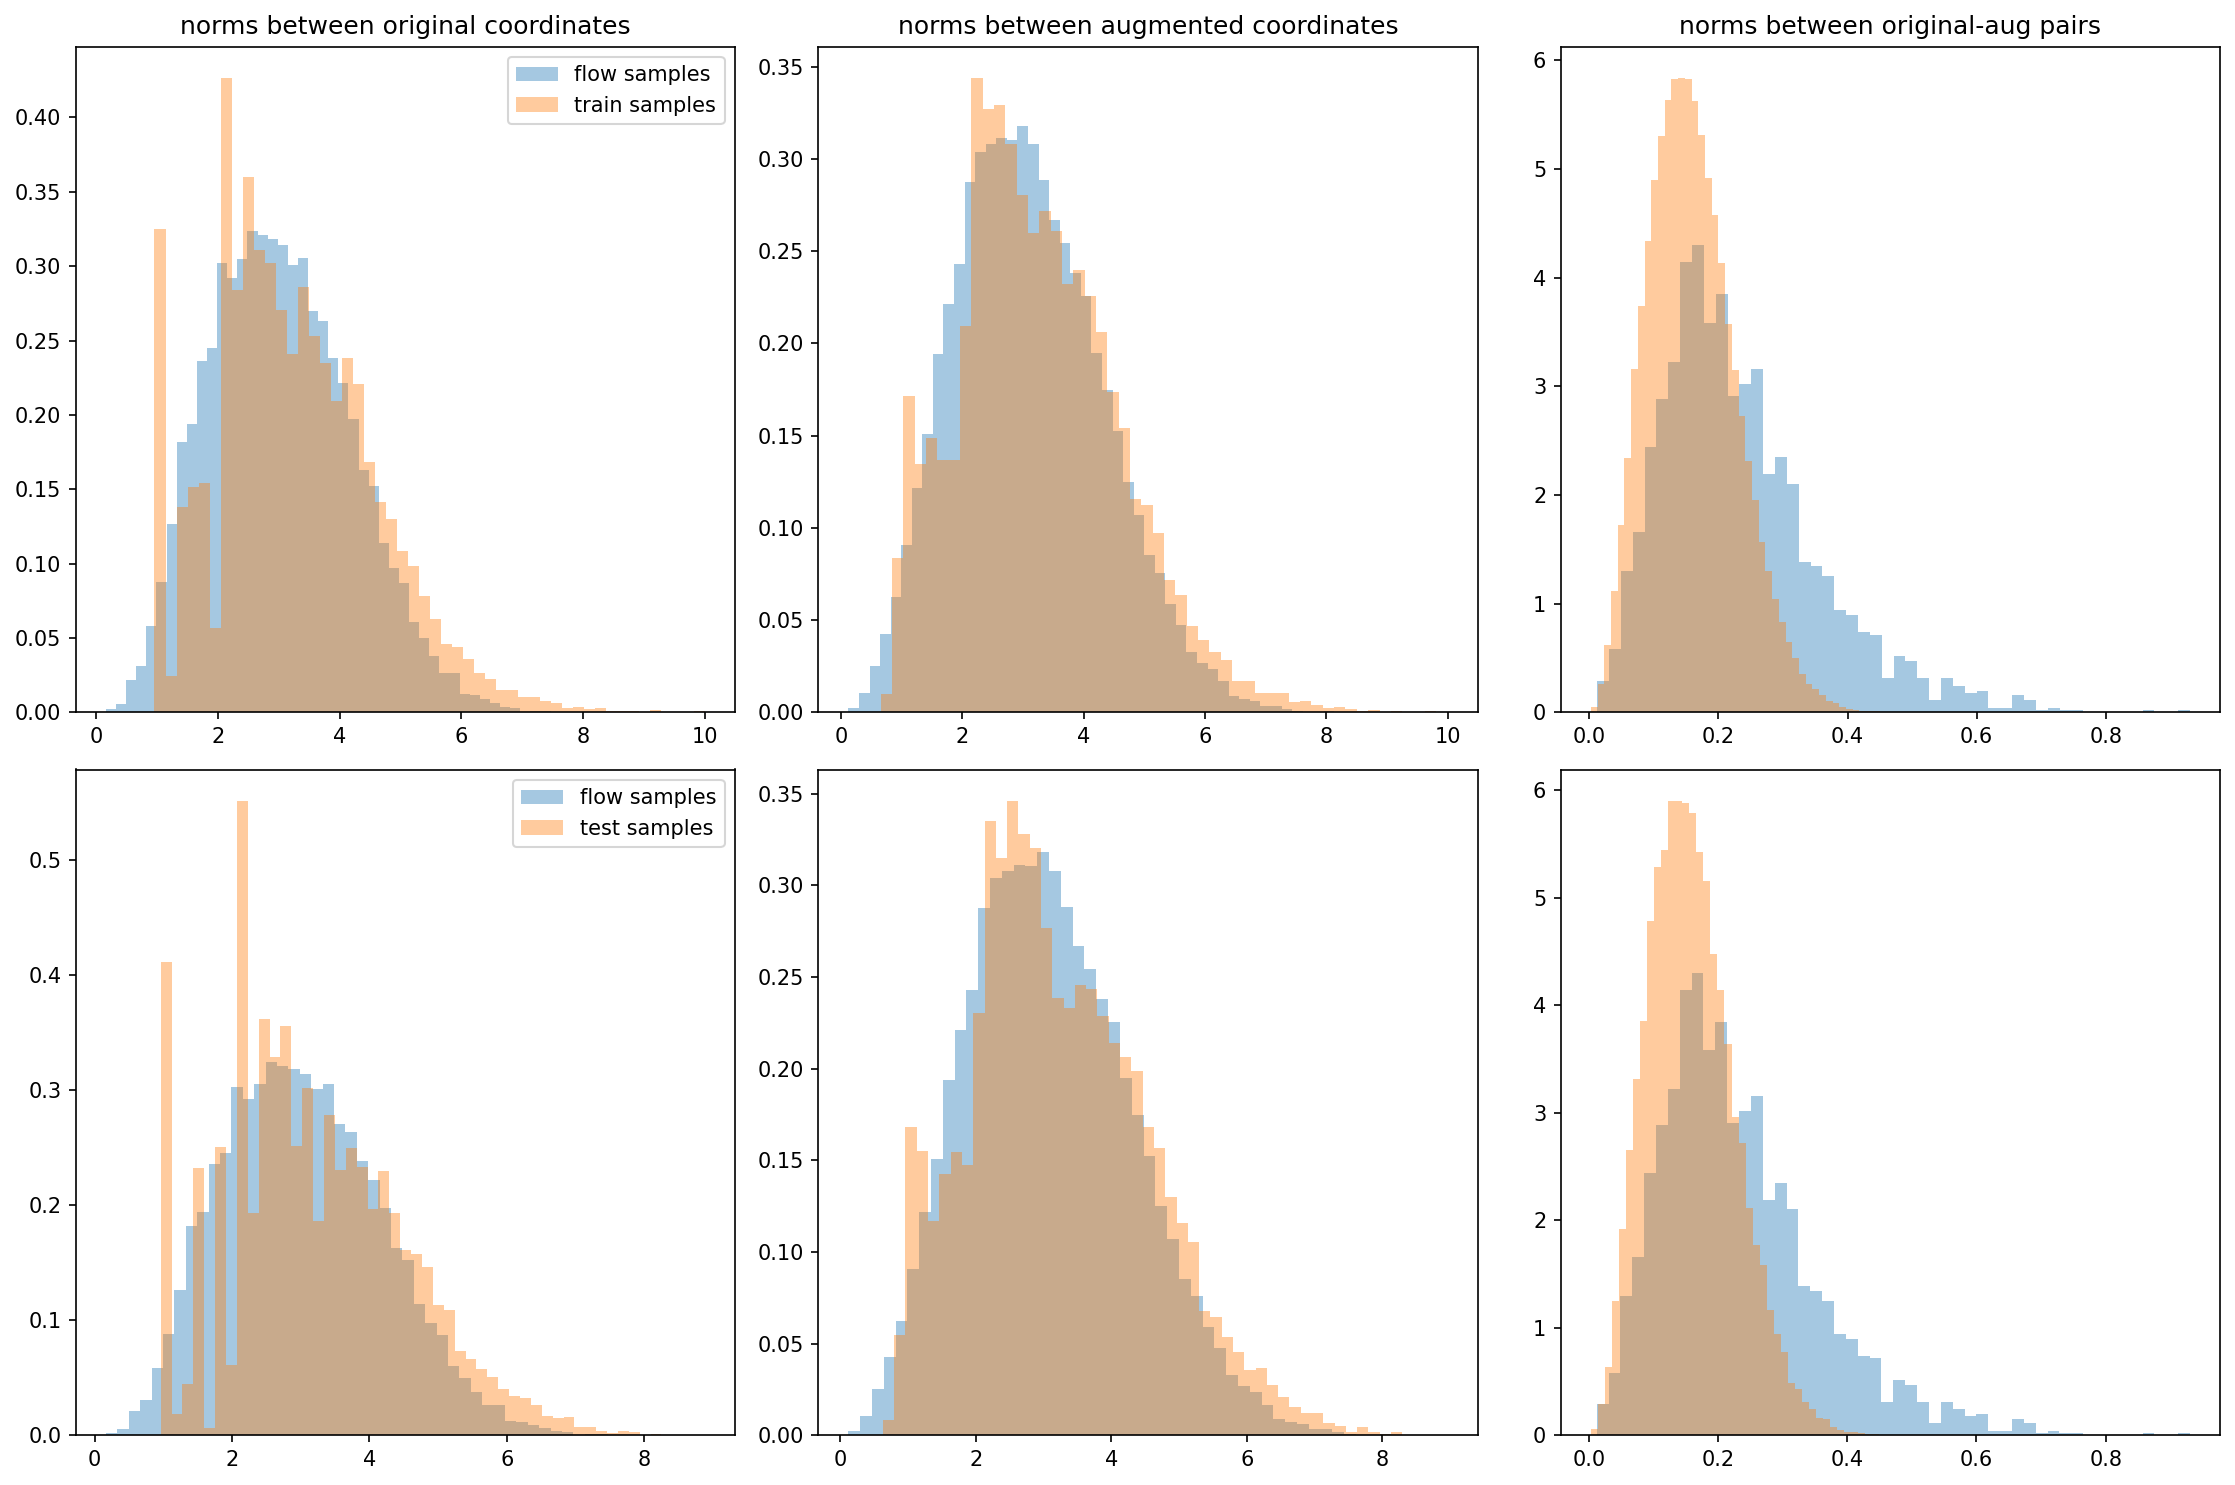

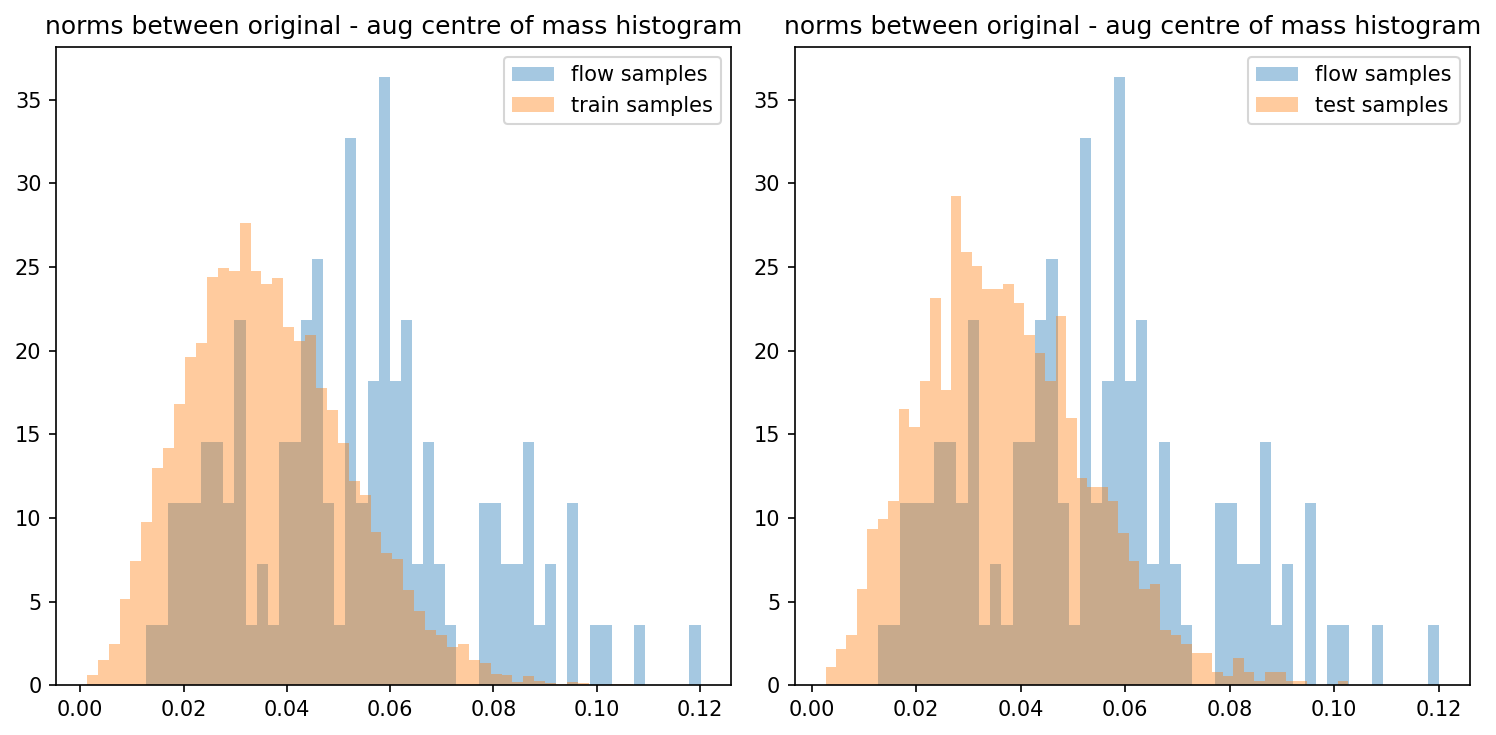

 34%|██████████████▌                            | 27/80 [04:04<12:19, 13.96s/it]

{'eval_log_lik': Array(-39.336697, dtype=float32), 'eval_marginal_log_lik': Array(-84.80473, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(8.159214e-05, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(2.0973413e-05, dtype=float32), 'mean_aug_orig_norm': Array(0.05429155, dtype=float32), 'mean_diff_x_space_after_group_action': Array(1.9566637, dtype=float32)}


 65%|███████████████████████████▉               | 52/80 [06:51<03:07,  6.69s/it]

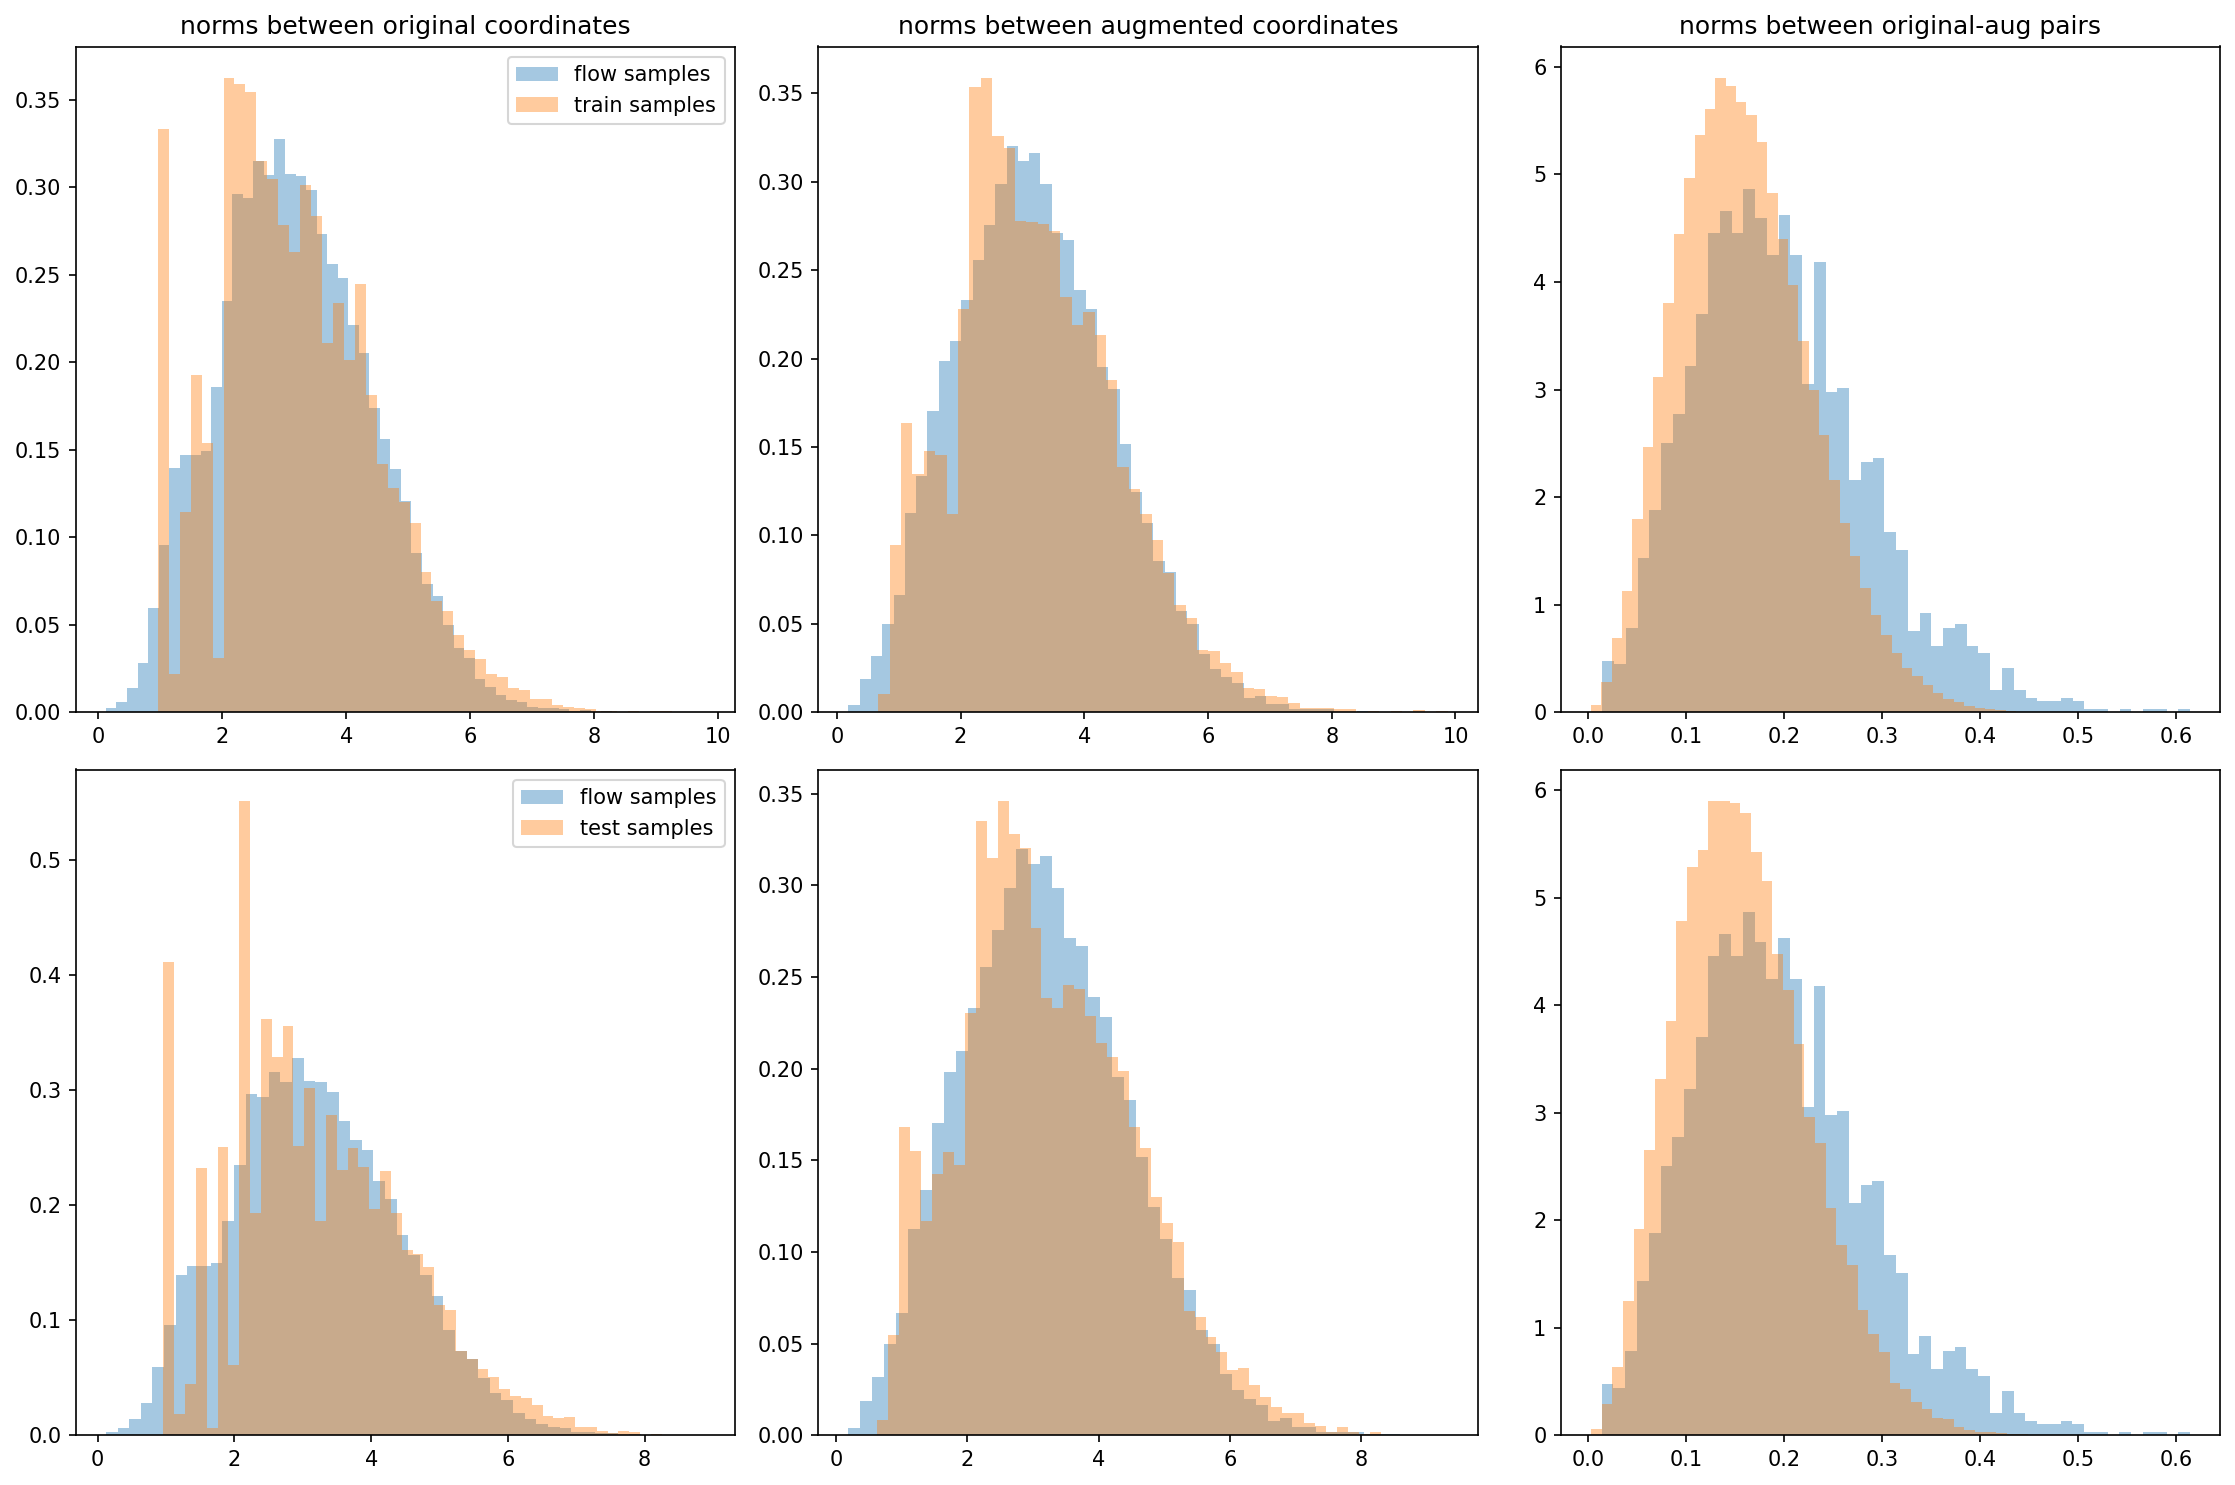

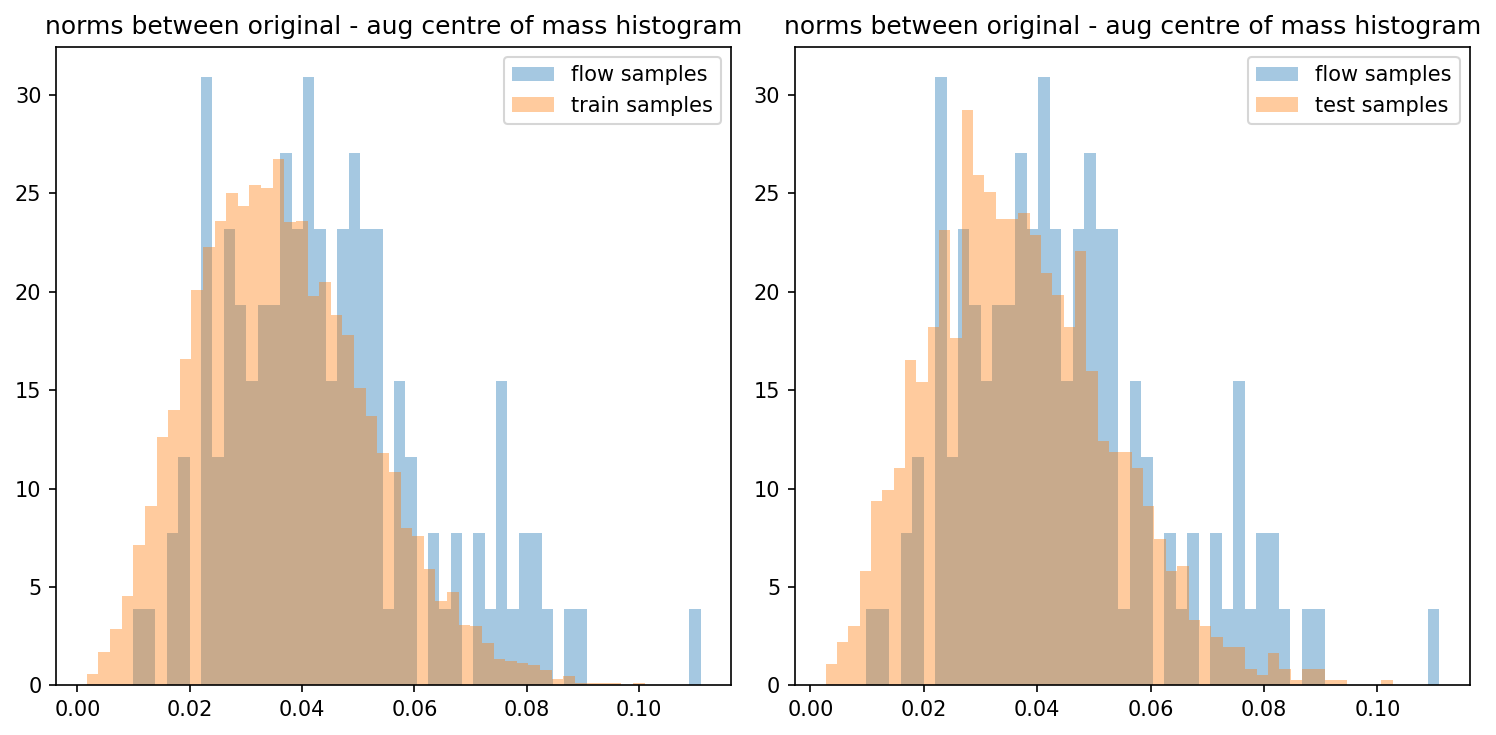

 66%|████████████████████████████▍              | 53/80 [07:22<06:14, 13.89s/it]

{'eval_log_lik': Array(-29.594398, dtype=float32), 'eval_marginal_log_lik': Array(-75.08296, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00019519, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(4.9387087e-05, dtype=float32), 'mean_aug_orig_norm': Array(0.04436082, dtype=float32), 'mean_diff_x_space_after_group_action': Array(1.9374793, dtype=float32)}


 99%|██████████████████████████████████████████▍| 79/80 [10:16<00:06,  6.70s/it]

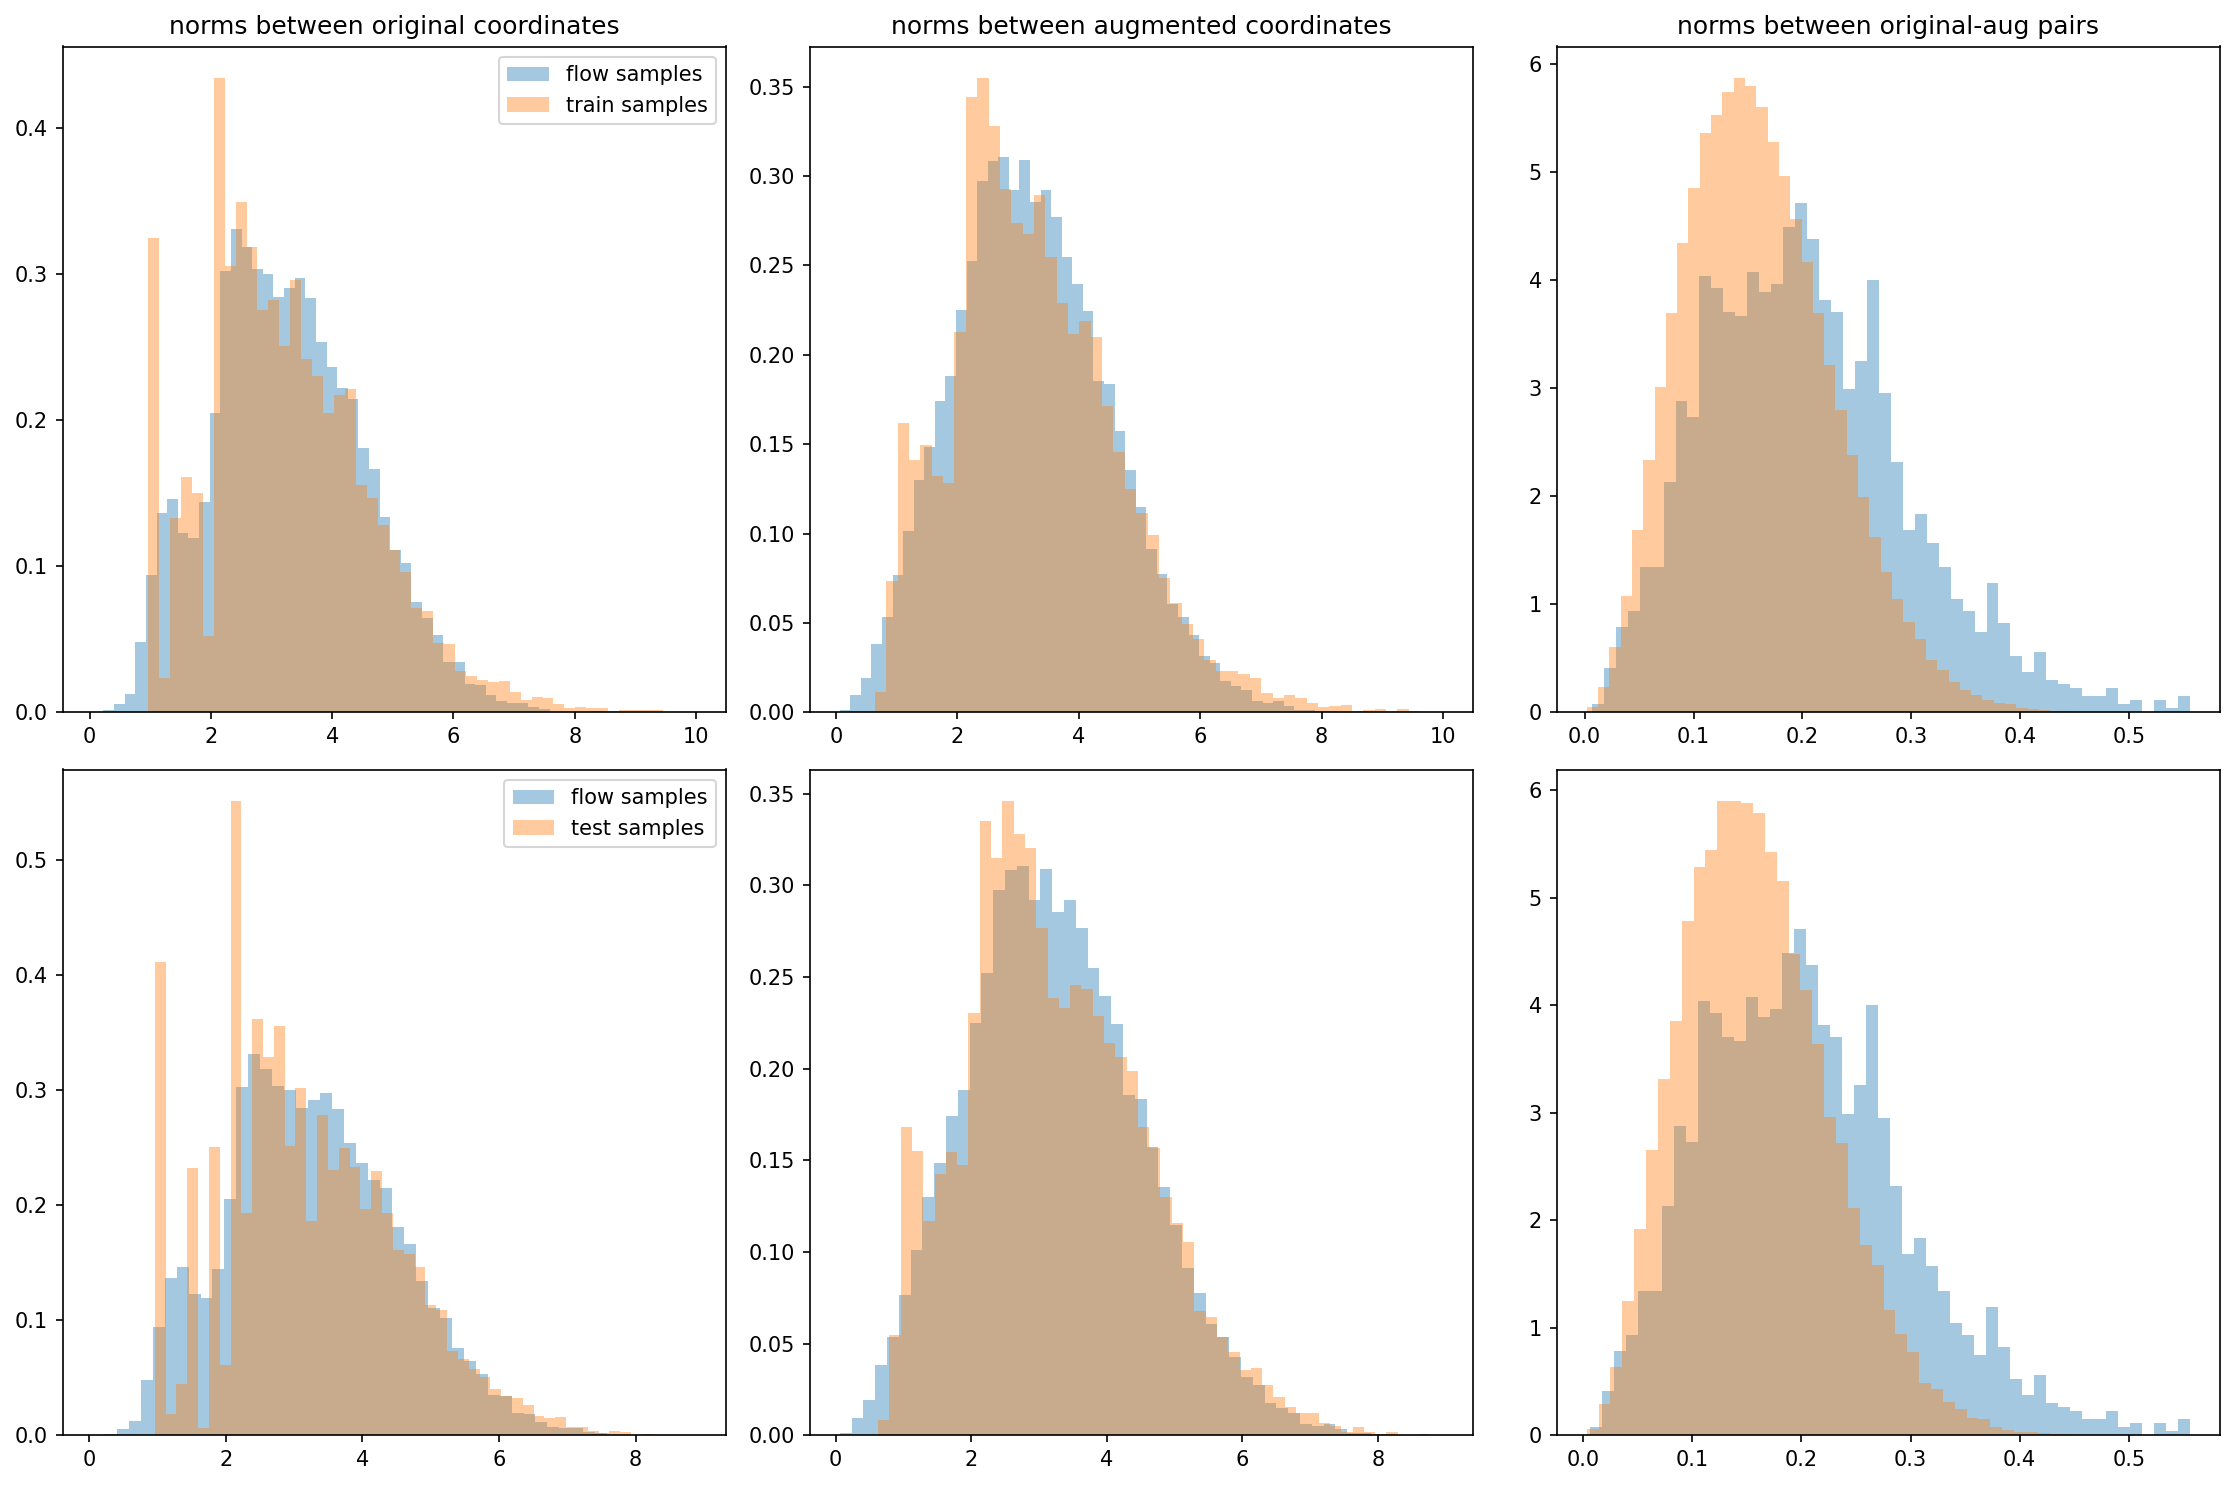

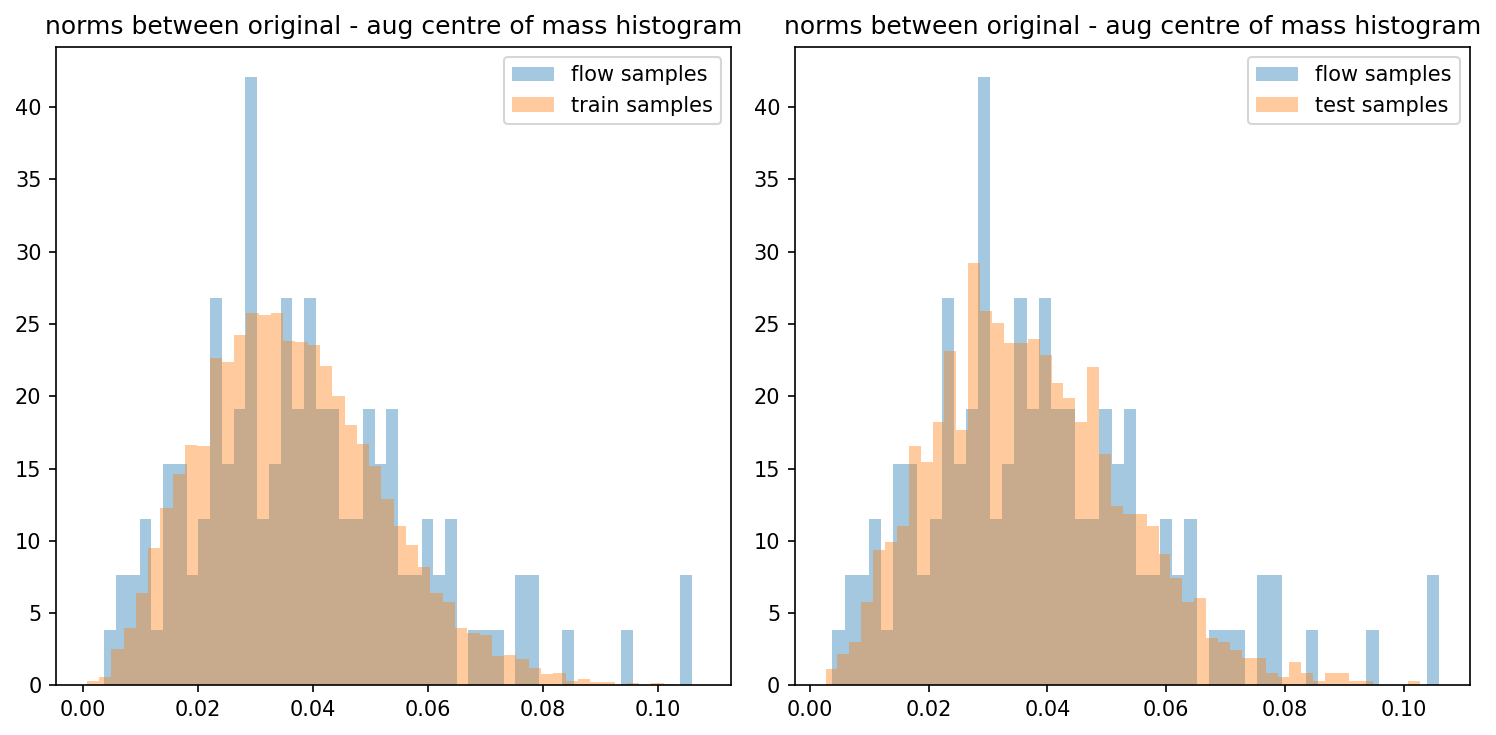

100%|███████████████████████████████████████████| 80/80 [10:47<00:00,  8.09s/it]


{'eval_log_lik': Array(-23.806883, dtype=float32), 'eval_marginal_log_lik': Array(-69.136986, dtype=float32), 'max_abs_diff_log_prob_after_group_action': Array(0.00025664, dtype=float32), 'mean_abs_diff_log_prob_after_group_action': Array(6.6829e-05, dtype=float32), 'mean_aug_orig_norm': Array(0.04489224, dtype=float32), 'mean_diff_x_space_after_group_action': Array(1.962207, dtype=float32)}


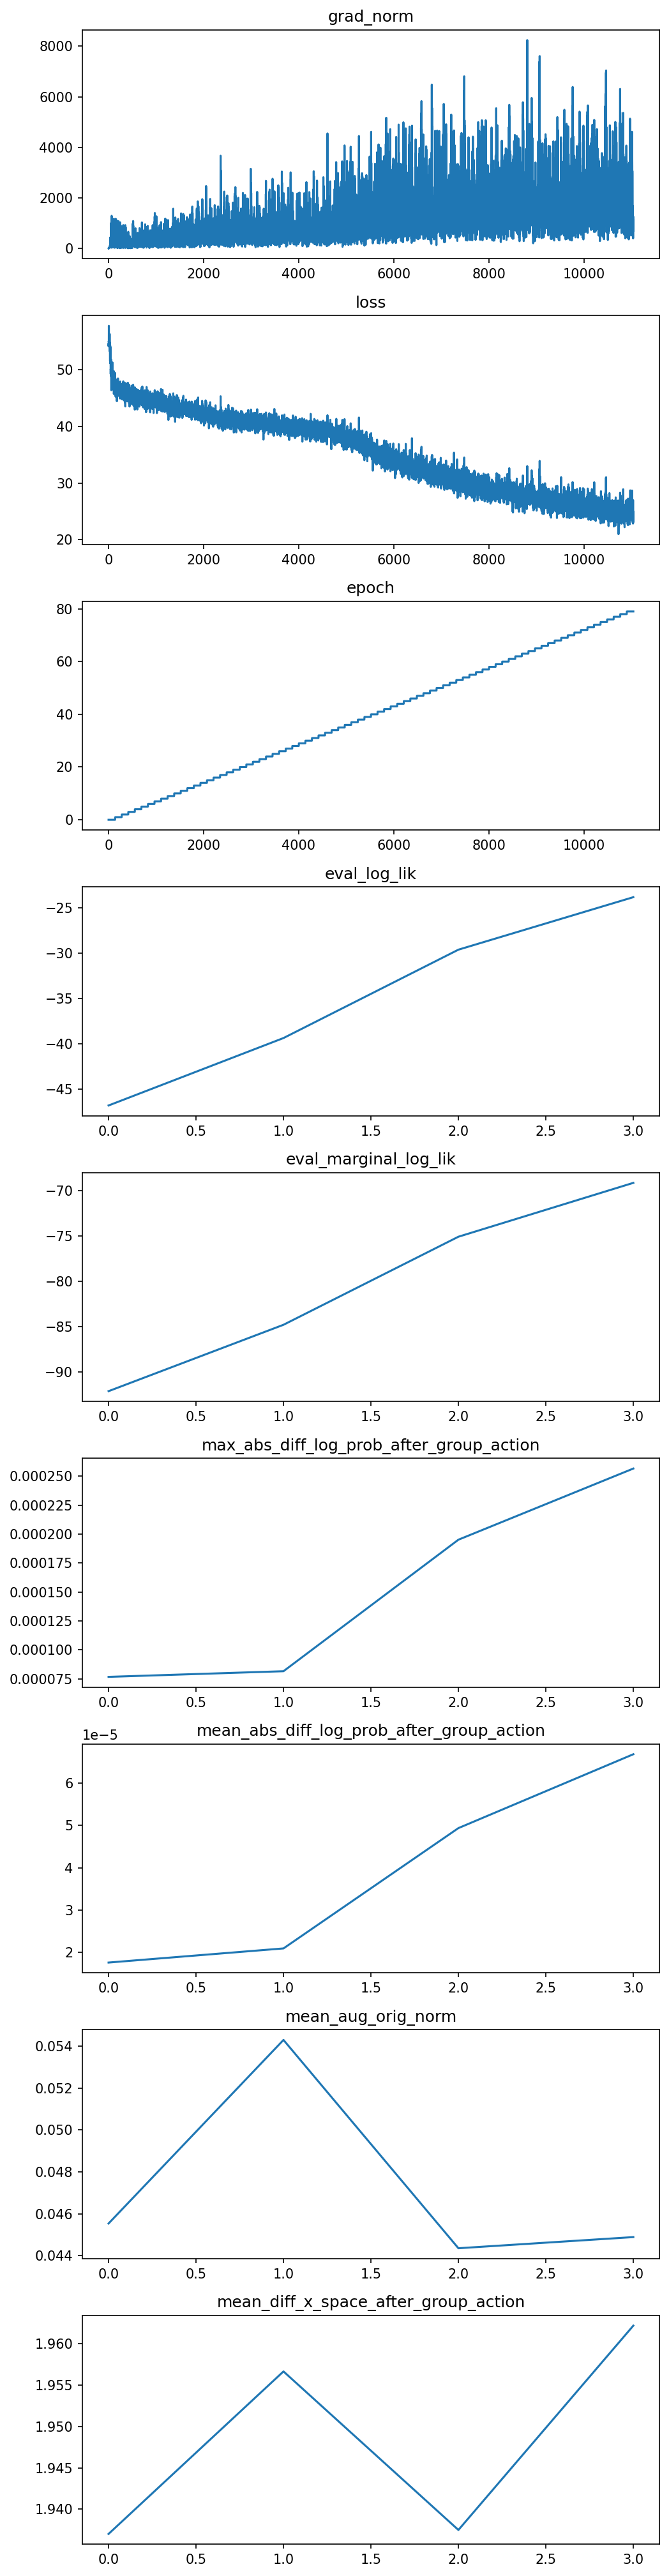

In [7]:
experiment_config = create_train_config(cfg, dim=3, n_nodes=19,
                                        load_dataset=load_dataset)

logger, params, log_prob_fn, sample_and_log_prob_fn = train(experiment_config)



In [16]:
train_data_original, test_data_original = load_dataset(cfg.training.batch_size, 1000, 1000)

[<Figure size 2250x1500 with 6 Axes>, <Figure size 1500x750 with 2 Axes>]

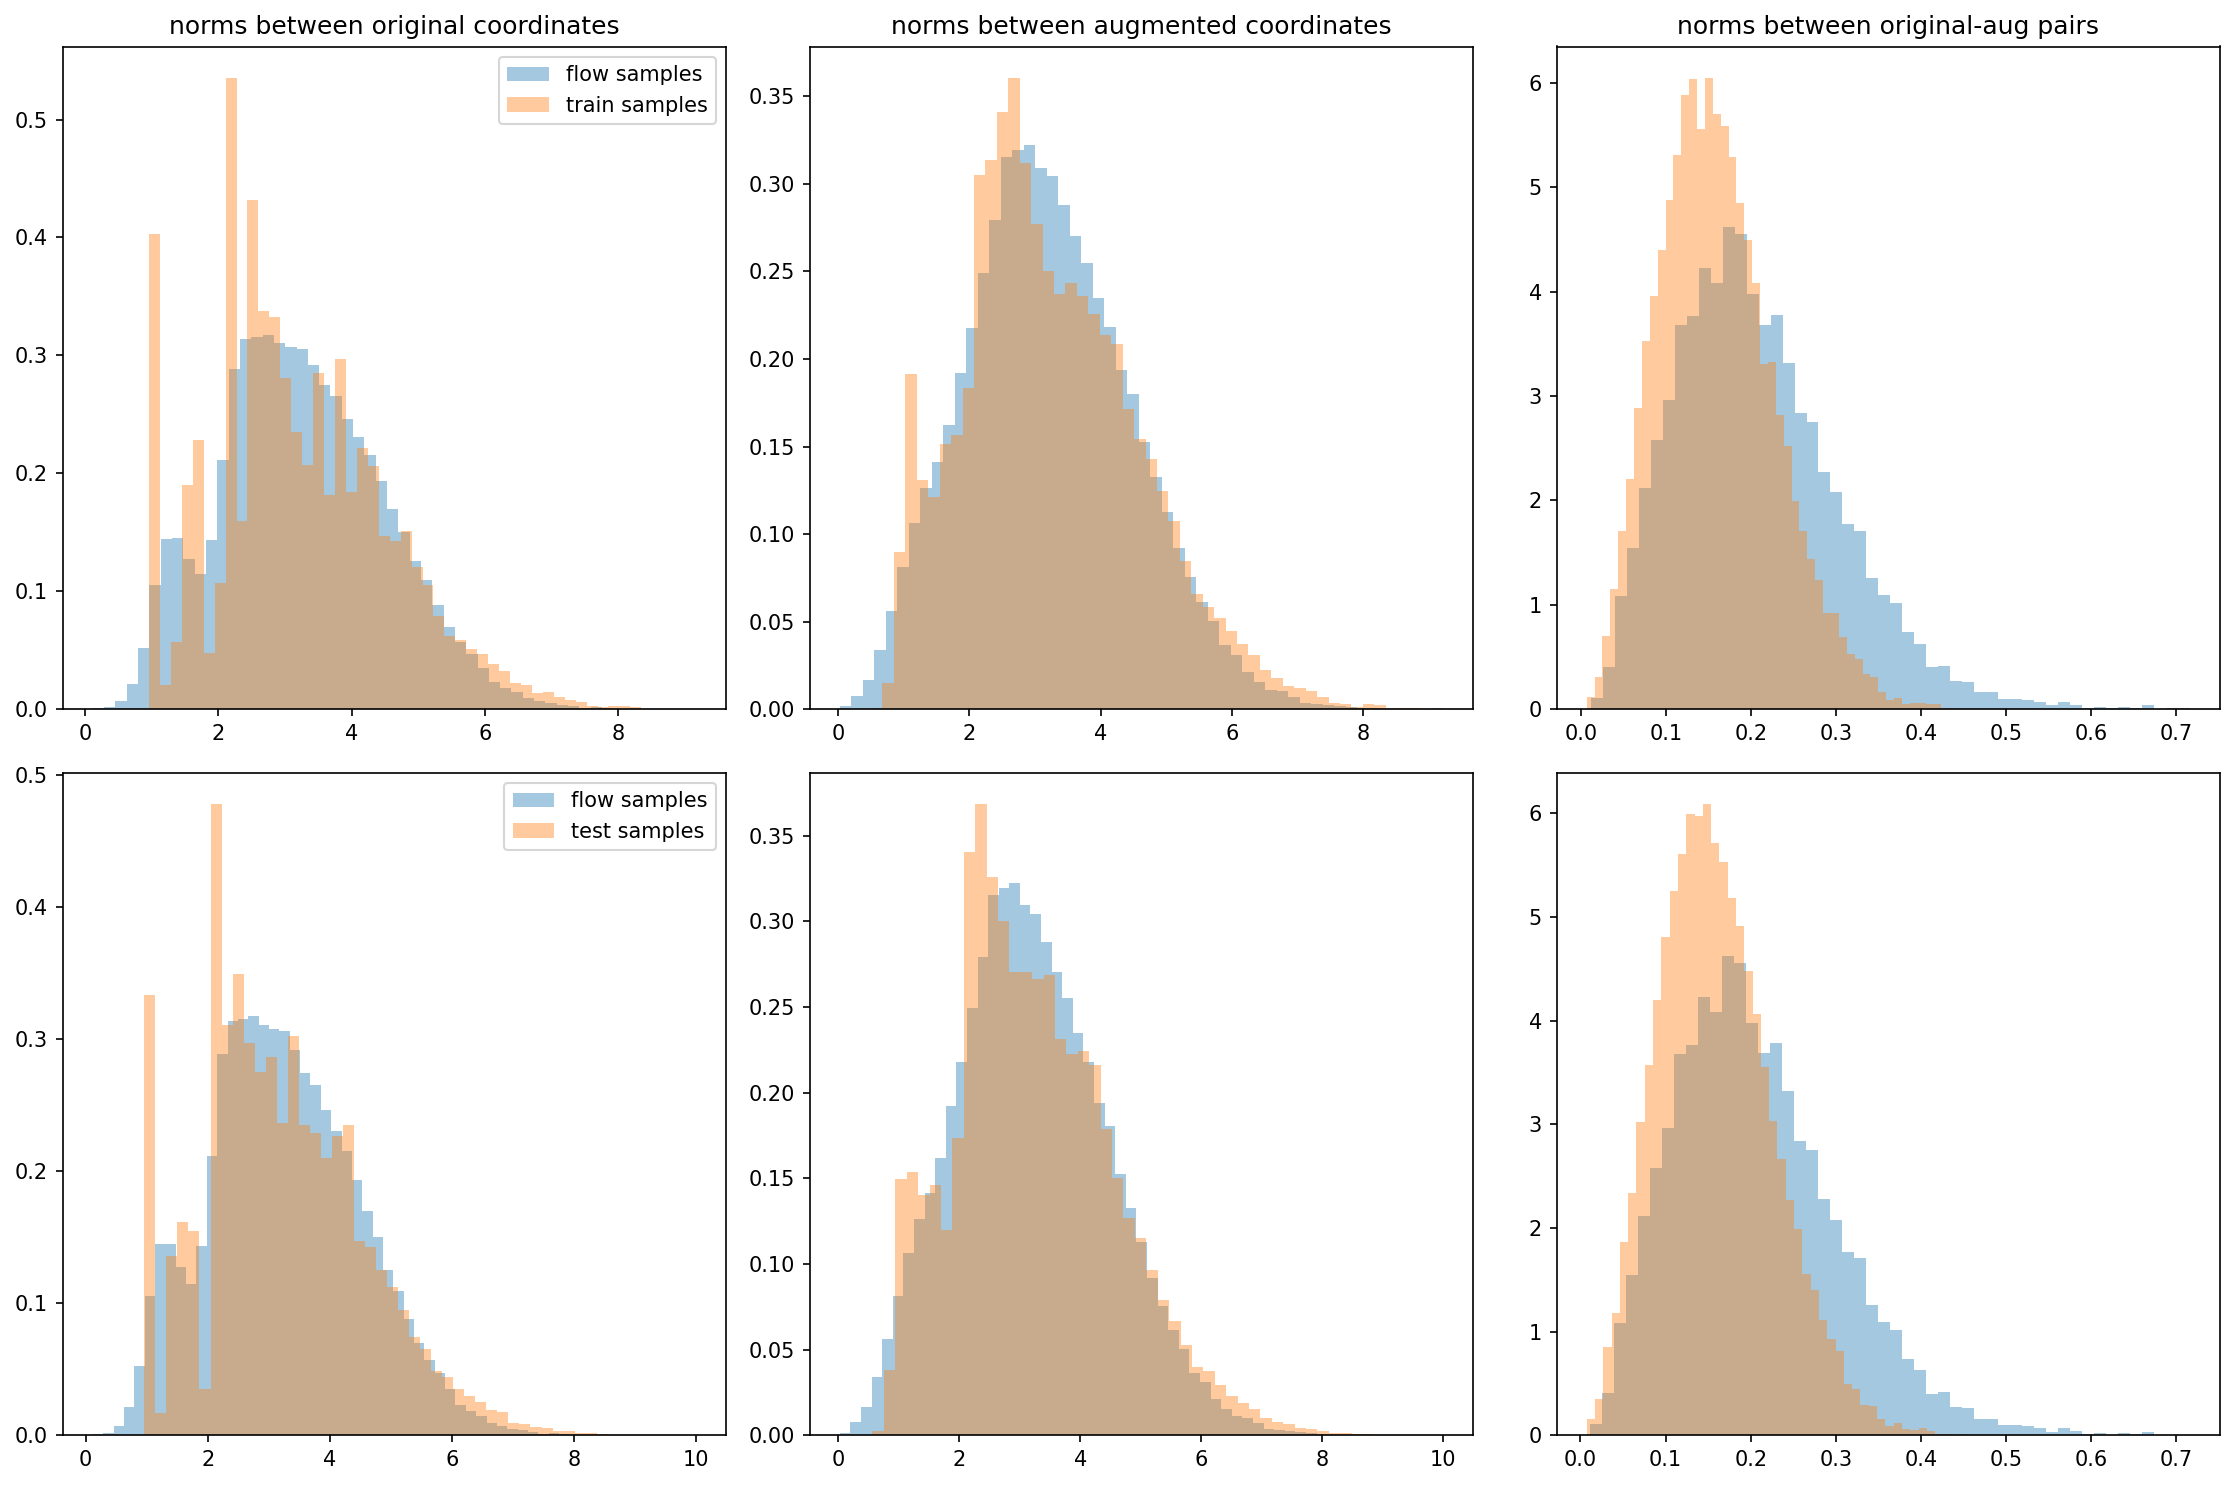

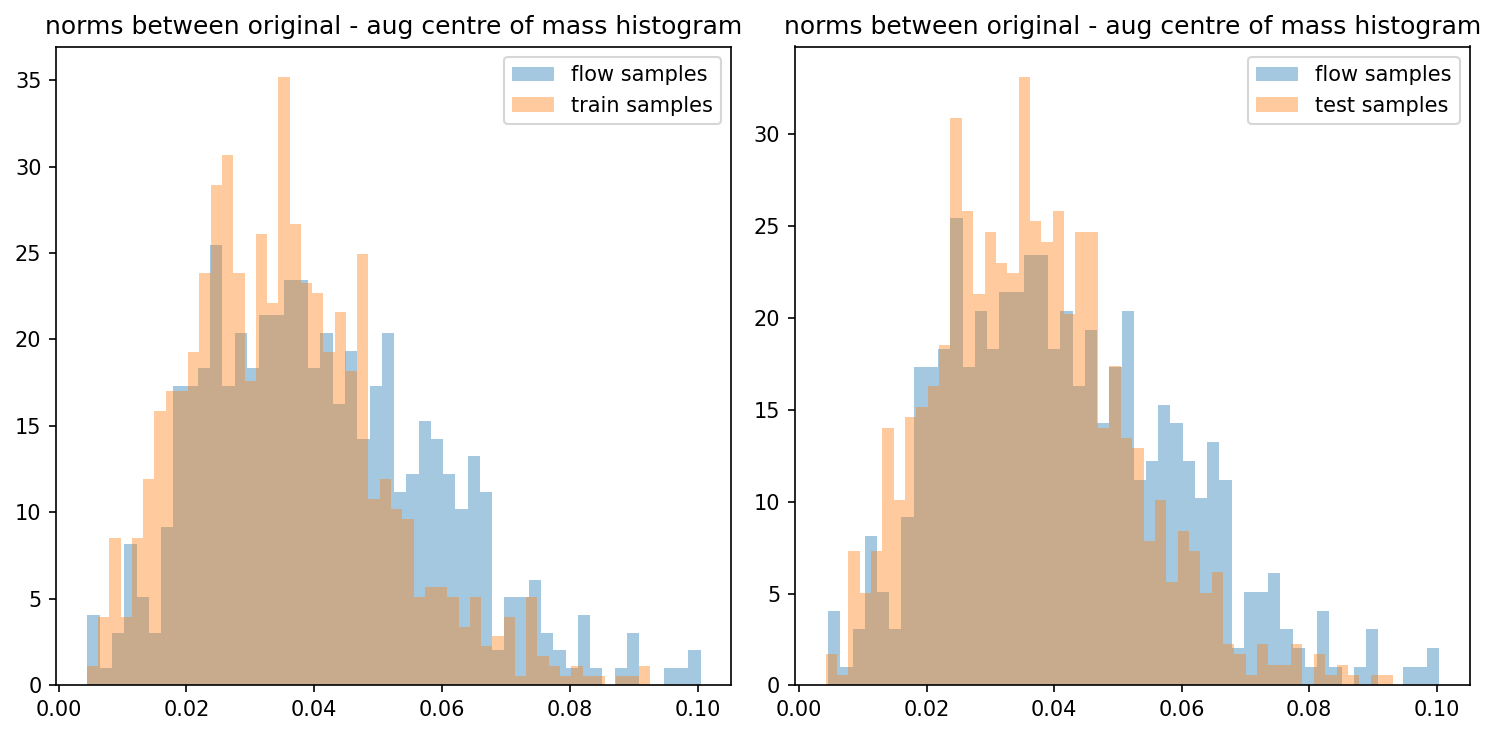

In [19]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
train_data = original_dataset_to_joint_dataset(train_data_original, subkey,
                                               global_centering=cfg.target.aug_global_centering,
                                               aug_scale=cfg.target.aug_scale)
key, subkey = jax.random.split(key)
test_data = original_dataset_to_joint_dataset(test_data_original, subkey,
                                              global_centering=cfg.target.aug_global_centering,
                                               aug_scale=cfg.target.aug_scale)

plot_batch_size = 512
sample_fn = sample_fn = lambda params, key, shape: sample_and_log_prob_fn.apply(params, key, shape)[0]
default_plotter(params, sample_fn, key, plot_batch_size, train_data, test_data)

In [22]:
eval_fn(params=params, x=test_data, flow_log_prob_fn=log_prob_fn,
                                flow_sample_and_log_prob_fn=sample_and_log_prob_fn,
                                key=jax.random.PRNGKey(1), batch_size=cfg.training.batch_size,
                                global_centering=cfg.target.aug_global_centering,
                                aug_scale=cfg.target.aug_scale,
                                K=50)

{'eval_log_lik': Array(-23.080572, dtype=float32),
 'eval_marginal_log_lik': Array(-63.73407, dtype=float32),
 'max_abs_diff_log_prob_after_group_action': Array(0.00024948, dtype=float32),
 'mean_abs_diff_log_prob_after_group_action': Array(6.531716e-05, dtype=float32),
 'mean_aug_orig_norm': Array(0.04277119, dtype=float32),
 'mean_diff_x_space_after_group_action': Array(1.9490414, dtype=float32)}